<a href="https://colab.research.google.com/github/NikitiusIvanov/ComputerVisionAgeRecognition/blob/main/age_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение возраста по фото

Задача построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Содержание

* Исследовательский анализ набора фотографий.
* Подготовка данных к обучению.
* Обучение модели и оценка качества.
* Анализ результатов работы модели и корректировка модели

## Полученные результаты

Средняя абсолютная ошибка модели на тестовой части выборки составила 8.05 лет

Оценки средний абсолютных ошибок прогноза модели по возрастным группам составили:

* 0-9 лет -- MAE = 5.8
* 10-19 лет -- MAE = 6.6
* 20-29 лет -- MAE = 5.0
* 30-39 лет -- MAE = 6.3
* 40-49 лет -- MAE = 10.1
* 50-59 лет -- MAE = 11.3
* 60-69 лет -- MAE = 11.5
* 70-79 лет -- MAE = 16.8
* 80-89 лет -- MAE = 23.6
* 90-99 лет -- MAE = 34.4




#1. Исследовательский анализ данных

* Построим график распределения возраста в выборке.
* Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет.
* Сделаем выводы о том, как результаты повлияют на обучение модели.


Импортируем необходимые библиотеки:

In [ ]:
from google.colab import drive
 
import numpy as np
import pandas as pd
 
from PIL import Image
import matplotlib.pyplot as plt
 
 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


Выведем на экран одно изображение из папки с изображениями

In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/practikum/cv/faces/faces_all.csv')
display(dataframe.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
dataframe.shape


(4555, 2)

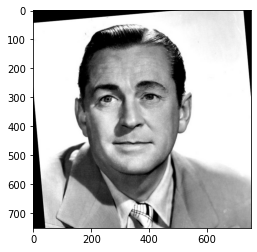

In [ ]:
plt.imshow(Image.open('/content/drive/MyDrive/practikum/cv/faces/all/000111.jpg_face.jpg'))

In [ ]:
np.asarray(Image.open('/content/drive/MyDrive/practikum/cv/faces/all/000110.jpg_face.jpg')).shape

(801, 800, 3)

Загрузим таблицу с именами файлов изображений и возрастом изображенных на них людей.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Выведем основные статистики по таблице

In [ ]:
display(dataframe.describe(include= 'all'))

,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,002420.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


Отобразим распределение возрастав в выборке в виде гистограммы

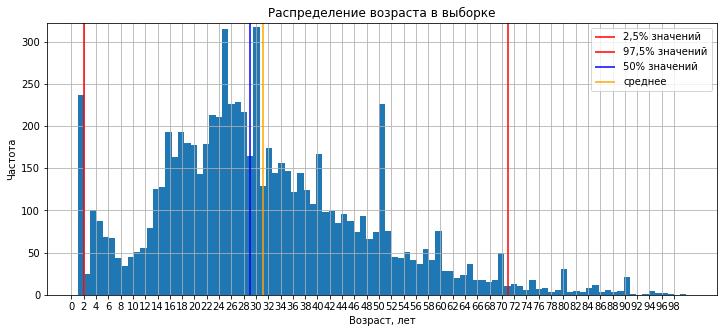

In [ ]:
dataframe['real_age'].hist(bins = len(dataframe['real_age'].unique()),
                     figsize = (12,5))
plt.vlines(
    x = dataframe['real_age'].quantile(0.025),
    ymin = 0,
    ymax = dataframe['real_age'].value_counts().max()+5,
    colors = 'r',
    label = '2,5% значений'
)

plt.vlines(
    x = dataframe['real_age'].quantile(0.975),
    ymin = 0,
    ymax = dataframe['real_age'].value_counts().max()+5,
    colors = 'r',
    label = '97,5% значений'
)

plt.vlines(
    x = dataframe['real_age'].quantile(0.5),
    ymin = 0,
    ymax = dataframe['real_age'].value_counts().max()+5,
    colors = 'b',
    label = '50% значений'
)

plt.vlines(
    x = dataframe['real_age'].mean(),
    ymin = 0,
    ymax = dataframe['real_age'].value_counts().max()+5,
    colors = 'orange',
    label = 'среднее'
)

plt.title('Распределение возраста в выборке')
plt.ylim(top = dataframe['real_age'].value_counts().max()+5)
plt.legend()
plt.ylabel('Частота')
plt.xticks(range(0, dataframe['real_age'].max(), 2))
plt.xlabel('Возраст, лет')
plt.show()

### Выводы

В нашем распоряжении набор данных из 7591 пары объектов - изображение лица человека и соответствующей записью о возрасте человека. 

Распределение объектов по возрасту не равномерное и напоминает по форме распределение Пуассона и похоже на распределение возраста в естественной популяции, со средним значением 31.2 и стандартным отклонением 17.14, при этом 95% значений лежат в диапазоне до 2 лет до 71 года. 

В выборке довольно в гораздо меньшем количестве представлены старшие возрастные поэтому можно предположить что значения ошибки на изображениях лиц пожилых людей будет больше.

#2. Подготовка данных

Всего в наборе данных 7591 уникальных изображений с лицами людей, но как мы уже увидели ранее старшие возарстные группы присутствуют в выборке гораздо в меньшем количестве что можно повлиять на точность модели.

Возможный вариант решения этой проблемы - создание копий изображений с помощью различных преобразований таких как: отражение, поворты, смещения.

Чтобы понять необходимо ли будет применять эту технику сначала мы обучим модель на исходном датасете, но чтобы была возможность корректно провести исследование необходимо будет заранение разделить выборку на тренировочную на которой будет применяться аугментация, и валидационную с тестовой на которых будем оценивать результат модели. Разделение произведем в пропорциях 3:1:1

In [ ]:
display(dataframe.shape)
test = dataframe.sample(frac = 0.2, random_state=12345)
display(test.shape)
test_index = test.index
dataframe = dataframe.query('index not in @test_index')
valid = dataframe.sample(frac = 0.25, random_state=12345)
display(valid.shape)
valid_index = valid.index
dataframe = dataframe.query('index not in @valid_index')
display(dataframe.shape)

(7591, 2)

(1518, 2)

(1518, 2)

(4555, 2)

Создадим генераторы для подачи порций (батчей) картинок в нашу будущую модель, отдельно для тренировочного и отдельно для валидационного датасета.

In [ ]:
path = '/content/drive/MyDrive/practikum/cv/faces/all/'

train_datagen = ImageDataGenerator(
    rescale = 1/255)

train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = dataframe,
        directory = path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345
        )

valid_datagen = ImageDataGenerator(
    rescale = 1/255)
    
valid_datagen_flow = valid_datagen.flow_from_dataframe(
        dataframe = valid,
        directory = path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345
        )

Found 4555 validated image filenames.
Found 1518 validated image filenames.


Выведем на экран 12 изображений из тренировочного генератора

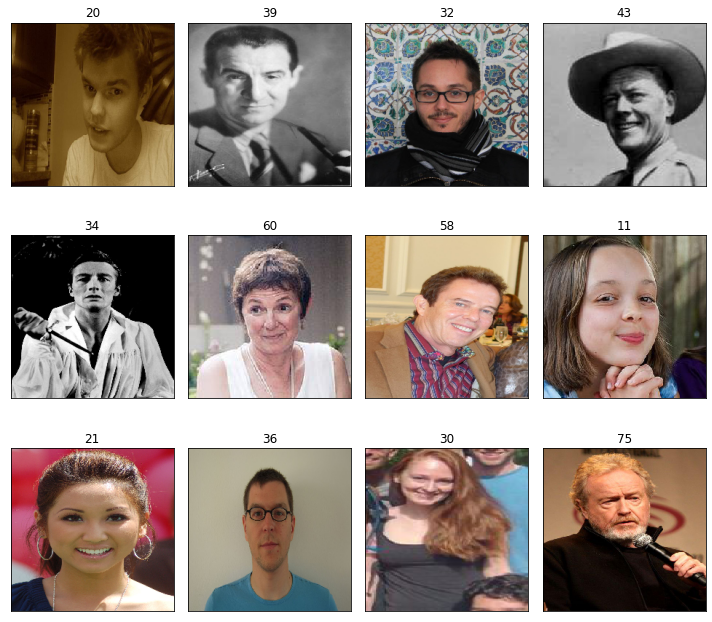

In [ ]:
x, y = next(train_datagen_flow)
fig = plt.figure(figsize = (10,10))
for i in range(12):
    fig.add_subplot(3,4, i+1)
    plt.imshow(x[i])
    plt.title(y[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

# 3. Обучение модели

Используем модель ResNet50, построенную реализующую принцип residual learning, который решает проблему затухания градиента в нейронных сетях с большим количеством сверточных слоев за счет передачи в более глубокий слой результата сложения исходного признака и результата последовательных сверток нескольких предыдущих слоев, в случае ResNet через каждые два слоя (https://arxiv.org/abs/1512.03385). 

В качестве основы мы будем использовать модель из библиотеки Keras (https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50) с весами, предобученными на датасете ImageNet содержащем более 12 миллионов изображений объектов размеченных по принадлежности к 1000 классам (https://www.image-net.org/). 

Чтобы модель решала задачу регрессии а не классификации мы заменим выходной слой содержащий 1000 нейронов с активацией sofmax на один нейрон c активационной функцией ReLu которая обращает в 0 отрицательные значениях выхода нейрона и оставляет неизменныеми положительные значения.

В качестве оптимизируемой на тестовом множестве функции потерь зададим среднюю квадратичную ошибку, а в качестве дополнительной метрики мы будем использовать среднюю абсолютную ошибку модели посчитанную на владиационной выборке. Алгоритм оптимизации ошибки зададим Adam (adaptive learning rate optimization algorithm) который адаптирует коэффициент на который увеличиваются веса в зависимости от значений антиградиента функции потерь, если антиградиент быстро растет -- значит что направление спуска оптимальное и веса будут изменяться быстрее, а когда рост антиградиента замедляется при подходе к минимуму то веса изменяются также медленнее, что позволяет не пропустить минимум при очень большом шаге.

In [ ]:
backbone = ResNet50(
        input_shape = (224, 224, 3),
        include_top=False,
        weights= 'imagenet'
    )
model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='relu'))
optimizer = Adam(learning_rate = 0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


Зададим количество шагов для обучения и валидации чтобы за одну эпоху проходили все объекты из обучающей выборки и за одну эпоху валидации проходили все объекты валидационной выборки, затем дообучим модель на 10 эпохах, и сохраним лучшую обученную модель, для дальшейшего использования.

In [ ]:
steps_train = train_datagen_flow.n // train_datagen_flow.batch_size
steps_valid = valid_datagen_flow.n // valid_datagen_flow.batch_size
print('Количество шагов на эпоху обучения: ', steps_train)
print('Количество шагов на эпоху валидации: ', steps_valid)

Количество шагов на эпоху обучения:  284
Количество шагов на эпоху валидации:  94


In [ ]:
path_model_1 = '/content/drive/MyDrive/practikum/cv/faces/model_1'

callback = keras.callbacks.ModelCheckpoint(
                     monitor= 'val_mae',
                     filepath = path_model_1,
                     save_weights_only = False,
                     save_best_only = True,
                     mode = 'min' 
                     )

model.fit(train_datagen_flow,
          validation_data= valid_datagen_flow,
          epochs = 10,
          steps_per_epoch = steps_train,
          validation_steps = steps_valid,
          callbacks = [callback])

Epoch 1/10
244/284 [========================>.....] - ETA: 2:23 - loss: 273.1639 - mae: 11.9932

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


284/284 [==============================] - 1392s 5s/step - loss: 254.5427 - mae: 11.5903 - val_loss: 624.1835 - val_mae: 19.7732


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/practikum/cv/faces/model_1/assets
Epoch 2/10
 26/284 [=>............................] - ETA: 49s - loss: 103.5336 - mae: 7.6565

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


284/284 [==============================] - 73s 256ms/step - loss: 96.3381 - mae: 7.4799 - val_loss: 344.3698 - val_mae: 13.9057


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/practikum/cv/faces/model_1/assets
Epoch 3/10
180/284 [==================>...........] - ETA: 21s - loss: 53.7893 - mae: 5.6868

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


284/284 [==============================] - 74s 261ms/step - loss: 52.3515 - mae: 5.6223 - val_loss: 153.5450 - val_mae: 9.1226


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/practikum/cv/faces/model_1/assets
Epoch 4/10
199/284 [====================>.........] - ETA: 17s - loss: 36.1954 - mae: 4.6491

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


284/284 [==============================] - 74s 261ms/step - loss: 36.3891 - mae: 4.6648 - val_loss: 123.7433 - val_mae: 8.4064


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/practikum/cv/faces/model_1/assets
Epoch 5/10
245/284 [========================>.....] - ETA: 8s - loss: 26.7881 - mae: 3.9783

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


284/284 [==============================] - 74s 259ms/step - loss: 26.5033 - mae: 3.9573 - val_loss: 117.5082 - val_mae: 8.2773


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/practikum/cv/faces/model_1/assets
Epoch 6/10
196/284 [===================>..........] - ETA: 18s - loss: 23.1020 - mae: 3.6512

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


284/284 [==============================] - 74s 260ms/step - loss: 23.0346 - mae: 3.6601 - val_loss: 133.8384 - val_mae: 8.4476
Epoch 7/10
284/284 [==============================] - 73s 257ms/step - loss: 21.4860 - mae: 3.5244 - val_loss: 140.7386 - val_mae: 8.7726
Epoch 8/10
284/284 [==============================] - 74s 259ms/step - loss: 19.2255 - mae: 3.3851 - val_loss: 108.9206 - val_mae: 7.8959


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/practikum/cv/faces/model_1/assets
Epoch 9/10
  6/284 [..............................] - ETA: 55s - loss: 14.8006 - mae: 3.0607

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


284/284 [==============================] - 74s 260ms/step - loss: 17.3206 - mae: 3.1604 - val_loss: 114.2418 - val_mae: 7.8891


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/practikum/cv/faces/model_1/assets
Epoch 10/10
 74/284 [======>.......................] - ETA: 43s - loss: 16.1073 - mae: 3.0506

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


284/284 [==============================] - 74s 260ms/step - loss: 15.7966 - mae: 3.0455 - val_loss: 113.6721 - val_mae: 8.0135


# Анализ модели
Загрузим обученную модель из директории и оценим её качество на тестовой выборке.

In [ ]:
res50_10 = keras.models.load_model(filepath='/content/drive/MyDrive/practikum/cv/faces/model_1')

Создадим генератор порций картинок из тестового множества для подачи в модель и получения оценки возраста

In [ ]:
path = '/content/drive/MyDrive/practikum/cv/faces/all/'
test_gen = ImageDataGenerator(rescale=1./255)
test_gen_flow = test_gen.flow_from_dataframe( 
        dataframe = test,
        directory = path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345,
        shuffle = False
        )

Found 1518 validated image filenames.


In [ ]:
res50_10.evaluate(test_gen_flow)

19/95 [=====>........................] - ETA: 2:07 - loss: 105.3935 - mae: 7.5826

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 266 bytes but o

95/95 [==============================] - 160s 2s/step - loss: 98.4247 - mae: 7.4907


[98.42466735839844, 7.4906511306762695]

Получим массив с оценками возраста для изображения лица на каждом фото

In [ ]:
predict = res50_10.predict(test_gen_flow)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 266 bytes but o

In [ ]:
predict_df = pd.DataFrame({'file_name': test['file_name'],
                            'predict': predict[:,0]})
predict_df.to_csv(
      path_or_buf = '/content/drive/MyDrive/practikum/cv/faces/predict_model_1.csv',
      sep = ',',
      index = None)

test_predict = predict_df.merge(test, how = 'left', on='file_name')
test_predict['abs_error'] = abs(test_predict['predict'] - test_predict['real_age'])
display(test_predict['abs_error'].mean())

test_predict['real_tenth'] = test_predict['real_age'] // 10
pivot_test_predict_1 = test_predict.groupby(by = 'real_tenth').mean()
pivot_test_predict_1.reset_index()

train_tentn = dataframe.copy()
train_tentn['real_tenth'] = train_tentn['real_age'] // 10
num_files = train_tentn.groupby(by = ['real_tenth'])['file_name'].count().reset_index()

pivot_test_predict_1 = pivot_test_predict_1.merge(num_files, on = 'real_tenth')
pivot_test_predict_1

7.490652151297832

,real_tenth,predict,real_age,abs_error,file_name
0,0,8.970812,4.305785,5.765311,405
1,1,21.883961,15.823529,6.655784,722
2,2,25.972586,24.667458,5.038039,1236
3,3,29.453611,33.789809,6.346194,939
4,4,35.170868,44.192090,10.114170,577
5,5,42.510693,53.229008,11.352135,360
6,6,52.306431,63.254545,11.555642,172
7,7,56.230598,73.000000,16.769401,77
8,8,60.042503,83.666667,23.624162,43
9,9,56.405449,90.800000,34.394553,23


Проверим предположение о том что модель хуже будет определять возраст по фотографиям пожилых людей, для этого напишем функцию, которая будет формировать сводную таблицу по возрастным категориям изображений людей, отображая по каждой 10-летней категории:
 * количество изображений в тренировочном наборе данных
 * среднюю абсолютную ошибку в категории
 * средний реальных возраст в категории
 * средний прогноз модели в категории

Получим сводную таблицу по возрастным категориям и таблицу с абсолютными ошибками по каждому объекту

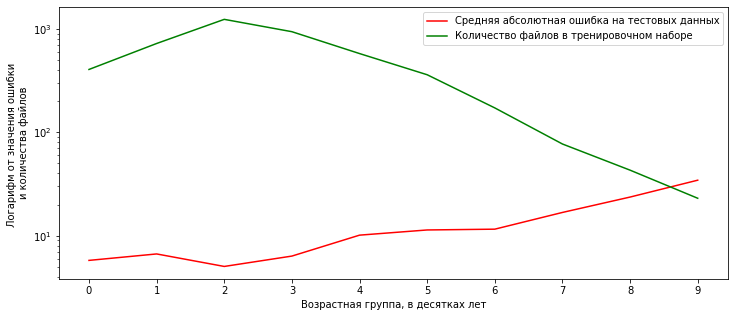

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (12,5))

axes.plot(pivot_test_predict_1['real_tenth'],
         (pivot_test_predict_1['mean_abs_err']),
         color = 'r',
          label = 'Средняя абсолютная ошибка на тестовых данных')
axes.plot(pivot_test_predict_1['real_tenth'],
         pivot_test_predict_1['num_files_train'],
         color = 'g',
          label = 'Количество файлов в тренировочном наборе'
          )
axes.set_yscale('log')
axes.set_ylabel('Логарифм от значения ошибки \nи количества файлов')
axes.set_xlabel('Возрастная группа, в десятках лет')
axes.set_xticks(list(range(10)))
axes.legend()
plt.show()

## Выводы
Как видно из таблицы средняя абсолютная ошибка модели по категории тем выше, чем меньше изображений в тренировочном множестве по данной категории.



# Улучшение качества модели


## Увеличение выборки. Аугментация данных

Сравним качество аналогичной модели обученной на выборке содержащей выровненное распределение объектов по возрасту.

Для этого создадим расширенный набор данных содержащий равное количество копии изображений каждой возрастной категории. Копии создадим с помощью применения к оригиальным изображениям преобразований, таких как деформация, отражение, сдвиги и зеральные отражения.

In [ ]:
path = '/content/drive/MyDrive/practikum/cv/faces/all/'

datagen_original = ImageDataGenerator(rescale=1./255)

augment_dataframe = pd.DataFrame({'file_name':[],
                                  'real_age':[]
                                  })
datagen_augmentation = ImageDataGenerator(rescale=1./255,
                                            rotation_range = 40,
                                            horizontal_flip = True,
                                            height_shift_range = 0.2,
                                            width_shift_range = 0.2,
                                            fill_mode = 'nearest'
                                          )
tenth = 0
for age in range(1, (dataframe['real_age'].max() // 10)+1 ):
  category = dataframe[(dataframe['real_age'] // 10 >=tenth)&
                       (dataframe['real_age'] // 10 < age)]
  coef = (dataframe.shape[0] // category.shape[0])
  
  datagen_original_flow = datagen_original.flow_from_dataframe(dataframe = category,                                                            
                                                            directory = path,
                                                            x_col='file_name',
                                                            y_col='real_age',
                                                            target_size=(224, 224),
                                                            batch_size=16,
                                                            class_mode='raw',
                                                            shuffle = False,
                                                            seed=12345)
  
  datagen_aug_flow = datagen_augmentation.flow_from_dataframe(dataframe = category,                                                            
                                                            directory = path,
                                                            x_col='file_name',
                                                            y_col='real_age',
                                                            target_size=(224, 224),
                                                            batch_size=16,
                                                            class_mode='raw',
                                                            shuffle = False,
                                                            seed=12345)
  
  for i in range(int(category.shape[0] // datagen_original_flow.batch_size)):
    x, y = next(datagen_original_flow)
    for j in range(x.shape[0]):
      aug_img = image.array_to_img(x[j])
      fname = 'orig'+'_'+datagen_original_flow.filenames[(i*datagen_original_flow.batch_size)+j]
      aug_img.save('/content/drive/MyDrive/practikum/cv/faces/face_augmentation/'+fname,
                  format = 'jpeg')
      augment_dataframe.loc[augment_dataframe.shape[0], :] = [fname, y[j]]
  print('in category from '+str(tenth*10)+' to '+str(age*10)+' years added '+str(category.shape[0])+' images')
  
  names = datagen_aug_flow.filenames
  names = names*(coef-1)
  for i in range(int((category.shape[0]*(coef-1)) // datagen_aug_flow.batch_size)):
    x, y = next(datagen_aug_flow)
    for j in range(x.shape[0]):
      aug_img = image.array_to_img(x[j])
      fname = str(i)+'_'+str(j)+'_'+names[(i*datagen_aug_flow.batch_size)+j]
      aug_img.save('/content/drive/MyDrive/practikum/cv/faces/face_augmentation/'+fname,
                  format = 'jpeg')
      augment_dataframe.loc[augment_dataframe.shape[0], :] = [fname, y[j]]
  
  augment_dataframe.to_csv(path_or_buf = '/content/drive/MyDrive/practikum/cv/faces/augment_dataframe.csv',
      sep = ',',
      index = None
      )
  print('in category from '+str(tenth*10)+' to '+str(age*10)+' years added '+str(category.shape[0]*(coef-1))+' transformed images') 
  tenth += 1


Found 405 validated image filenames.
Found 405 validated image filenames.
in category from 0 to 10 years added 405 images
in category from 0 to 10 years added 4050 transformed images
Found 722 validated image filenames.
Found 722 validated image filenames.
in category from 10 to 20 years added 722 images
in category from 10 to 20 years added 3610 transformed images
Found 1236 validated image filenames.
Found 1236 validated image filenames.


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


in category from 20 to 30 years added 1236 images
in category from 20 to 30 years added 2472 transformed images
Found 939 validated image filenames.
Found 939 validated image filenames.
in category from 30 to 40 years added 939 images
in category from 30 to 40 years added 2817 transformed images
Found 577 validated image filenames.
Found 577 validated image filenames.
in category from 40 to 50 years added 577 images
in category from 40 to 50 years added 3462 transformed images
Found 360 validated image filenames.
Found 360 validated image filenames.
in category from 50 to 60 years added 360 images
in category from 50 to 60 years added 3960 transformed images
Found 172 validated image filenames.
Found 172 validated image filenames.
in category from 60 to 70 years added 172 images
in category from 60 to 70 years added 4300 transformed images
Found 77 validated image filenames.
Found 77 validated image filenames.
in category from 70 to 80 years added 77 images
in category from 70 to 80 ye

In [ ]:
augment_dataframe.to_csv(path_or_buf = '/content/drive/MyDrive/practikum/cv/faces/augment_dataframe.csv',
      sep = ',',
      index = None
      )

NameError: ignored

In [ ]:
augment_dataframe = pd.read_csv('/content/drive/MyDrive/practikum/cv/faces/augment_dataframe.csv')
augment_dataframe.shape

(40233, 2)

In [ ]:
display(augment_dataframe.shape)

aug_valid_df = augment_dataframe.sample(frac = 0.2, random_state=12345)
display(aug_valid_df.shape)
valid_aug_index = aug_valid_df.index
aug_train_df = augment_dataframe.query('index not in @valid_aug_index')
display(aug_train_df.shape)

(40233, 2)

(8047, 2)

(32186, 2)

In [ ]:
path_aug = '/content/drive/MyDrive/practikum/cv/faces/face_augmentation/'

augmentation_gen = ImageDataGenerator(
    rescale= 1./255
    )

aug_train_datagen_flow = augmentation_gen.flow_from_dataframe(
        dataframe = aug_train_df,
        directory = path_aug,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345
        )

  
aug_valid_datagen_flow = augmentation_gen.flow_from_dataframe(
        dataframe = aug_valid_df,
        directory = path_aug,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345
        )

Found 32186 validated image filenames.
Found 8047 validated image filenames.


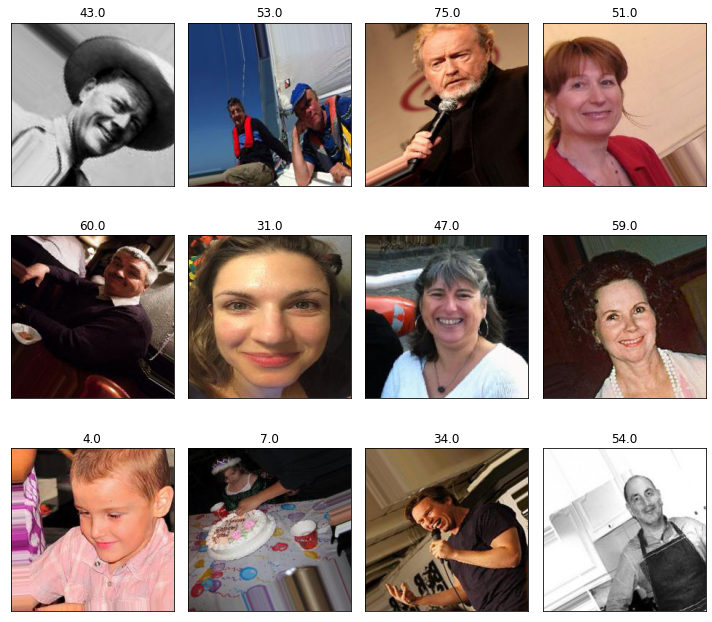

In [ ]:
x, y = next(aug_train_datagen_flow)
fig = plt.figure(figsize = (10,10))
for i in range(12):
    fig.add_subplot(3,4, i+1)
    plt.imshow(x[i])
    plt.title(y[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Обучение модели

Зададим количество шагов для обучения и валидации таким образом, чтобы за одну эпоху проходили все объекты.

In [ ]:
steps_train = aug_train_datagen_flow.n // aug_train_datagen_flow.batch_size
steps_valid = aug_valid_datagen_flow.n // aug_valid_datagen_flow.batch_size

print('Количество шагов на эпоху обучения: ', steps_train)
print('Количество шагов на эпоху валидации: ', steps_valid)


Количество шагов на эпоху обучения:  2011
Количество шагов на эпоху валидации:  502


Создадим такую же модель, как и при обучении на исходном датасете.

In [ ]:
backbone = ResNet50(
        input_shape = (224, 224, 3),
        include_top=False,
        weights= 'imagenet'
    )
model_aug = Sequential()
model_aug.add(backbone)
model_aug.add(GlobalAveragePooling2D())
model_aug.add(Dense(1, activation='relu'))
optimizer = Adam(learning_rate = 0.0001)
model_aug.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
model_aug.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


Обучим модель на пяти эпохах

In [ ]:
path_model = '/content/drive/MyDrive/practikum/cv/faces/models_aug/model_5_epochs'

callback = keras.callbacks.ModelCheckpoint(
                     monitor= 'val_mae',
                     filepath = path_model,
                     save_weights_only = False,
                     save_best_only = True,
                     mode = 'min')

history = model_aug.fit(aug_train_datagen_flow,
          validation_data= aug_valid_datagen_flow,
          epochs = 5,
          steps_per_epoch = steps_train,
          validation_steps = steps_valid,
          callbacks = [callback],
          workers = -1,
          use_multiprocessing = True)

Epoch 1/5
2011/2011 [==============================] - 8798s 4s/step - loss: 190.3502 - mae: 9.8881 - val_loss: 83.0841 - val_mae: 7.0286


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/practikum/cv/faces/models_aug/model_5_epochs/assets
Epoch 2/5
2011/2011 [==============================] - 482s 239ms/step - loss: 51.5938 - mae: 5.4582 - val_loss: 71.6817 - val_mae: 6.6437


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/practikum/cv/faces/models_aug/model_5_epochs/assets
Epoch 3/5
2011/2011 [==============================] - 473s 235ms/step - loss: 30.4936 - mae: 4.1675 - val_loss: 37.7366 - val_mae: 4.3668


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/practikum/cv/faces/models_aug/model_5_epochs/assets
Epoch 4/5
2011/2011 [==============================] - 475s 236ms/step - loss: 26.8859 - mae: 3.8574 - val_loss: 39.6949 - val_mae: 4.6195
Epoch 5/5
2011/2011 [==============================] - 473s 235ms/step - loss: 19.3343 - mae: 3.3001 - val_loss: 28.8630 - val_mae: 4.0231


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/practikum/cv/faces/models_aug/model_5_epochs/assets


## Анализ модели

Загрузим обученную модель модель и сравним её качество с моделью, обученной на исходном датасете.

In [ ]:
res50_aug = keras.models.load_model('/content/drive/MyDrive/practikum/cv/faces/faces_aug_model_2')

In [ ]:
res50_aug.evaluate(test_gen_flow)

20/95 [=====>........................] - ETA: 7:30 - loss: 121.5805 - mae: 8.1686

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 266 bytes but o

95/95 [==============================] - 580s 6s/step - loss: 117.8817 - mae: 8.0470


[117.88172149658203, 8.046993255615234]

In [ ]:
predict_aug = res50_aug.predict(test_gen_flow)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 266 bytes but o

In [ ]:
predict_aug_df = pd.DataFrame({'file_name': test['file_name'],
                            'predict': predict_aug[:,0]})
test_predict_aug = predict_aug_df.merge(test, how = 'left', on='file_name')
test_predict_aug['abs_error'] = abs(test_predict_aug['predict'] - test_predict_aug['real_age'])
display(test_predict_aug['abs_error'].mean())
test_predict_aug['real_tenth'] = test_predict_aug['real_age'] // 10
pivot_test_predict = test_predict_aug.groupby(by = 'real_tenth').mean().reset_index()
pivot_test_predict['error_before'] = pivot_test_predict_1['abs_error']
pivot_test_predict['num_files'] = pivot_test_predict_1['file_name']
pivot_test_predict['differences'] = pivot_test_predict['error_before'] - pivot_test_predict['abs_error']
pivot_test_predict

8.046991932043886

,real_tenth,predict,real_age,abs_error,error_before,num_files,differences
0,0,10.879346,4.305785,7.722579,5.765311,405,-1.957268
1,1,21.391088,15.823529,6.221951,6.655784,722,0.433833
2,2,24.841080,24.667458,5.488810,5.038039,1236,-0.450771
3,3,28.909885,33.789809,7.871395,6.346194,939,-1.525201
4,4,35.485485,44.192090,10.073119,10.114170,577,0.041050
5,5,41.887093,53.229008,12.485444,11.352135,360,-1.133309
6,6,52.860329,63.254545,11.630688,11.555642,172,-0.075046
7,7,56.065304,73.000000,16.934695,16.769401,77,-0.165294
8,8,66.731842,83.666667,16.934822,23.624162,43,6.689340
9,9,52.156277,90.800000,38.643723,34.394553,23,-4.249170
